# Water Survey of Canada

Historical data for lake levels and stream flows in the Rainy Lake watershed are publically available from several sources including the [Water Survey of Canada](http://wateroffice.ec.gc.ca/).

For the calculations in these notebooks, the [HYDAT database](https://www.ec.gc.ca/rhc-wsc/default.asp?lang=En&n=9018B5EC-1) containing historical data from the water survey of Canada was downloaded from Environment Canada. The database consists of a Microsoft Access .mdb file. Individual tables (STATIONS, DLY_FLOWS, and DLY_LEVELS) from the database were extracted to .csv files using [MDB Explorer](http://www.mdbexplorer.com/) and stored in the data directory.

This notebook extracts python dataframes from the .csv files, then creates two dataframes, RL and NL, for daily levels on Rainy and Namakan lakes, and RR for flows on Rainy River.

## Initialization

### Load Python Modules

In [1]:
# Display graphics inline with the notebook
%matplotlib notebook

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
import requests

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

### Read Data Tables

Before proceeding, download the HYDAT.mdb downloaded from Environment Canada, extract tables `STATIONS`, `DLY_FLOWS` and `DLY_LEVELS` and store as CSV formatted file. The name of the directory is encoded as `HYDAT_dir`.

The following cell checks the repository data directory for the existance of an HDF5 formatted file `hydat.h5` which is intended to be a small cache of the HYDAT data relevant to the Rainy/Namakan Lake system. If so, the data is read from `hydat.h5`. Otherwise, if the file does not exist, the entire HYDAT data based is read from CSV formatted files located in the directory `HYDAT_dir`.

In [3]:
from os.path import isfile

# Directory where data files have been stored
HYDAT_dir = "/Users/jeff/Box Sync/RLPOA Technical Committee/Historical Data/HYDAT/"

# check if a hydat.h5 file is the repository data directory. Read from there, otherwise
# read HYDAT CSV tables.
if isfile('../data/hydat.h5'):
    hydat = pd.HDFStore('../data/hydat.h5')
    STATIONS = hydat['STATIONS']
    DLY_FLOWS = hydat['DLY_FLOWS']
    DLY_LEVELS = hydat['DLY_LEVELS']
    hydat.close()
    print hydat
else:
    # The following csv data tables were extracted from the HYDAT .mdb dataset
    STATIONS = pd.read_csv(HYDAT_dir + 'STATIONS.csv', index_col = 0);
    DLY_FLOWS = pd.read_csv(HYDAT_dir + 'DLY_FLOWS.csv');
    DLY_LEVELS = pd.read_csv(HYDAT_dir + 'DLY_LEVELS.csv');

print "STATIONS.size = ", STATIONS.size
print "DLY_LEVELS.size = ", DLY_LEVELS.size
print "DLY_FLOWS.size = ", DLY_FLOWS.size

STATIONS.size =  108850
DLY_LEVELS.size =  40500274
DLY_FLOWS.size =  111069792


## Mapping WSC Stations

The HYDAT database is a collection of data associated with monitoring stations located throughout Canada. The STATIONS table contains a list of stations and attributes, including the latitude and longitude of their position. As an example, here we list attributes for 05PB007, a station monitoring the level of Rainy Lake near Fort Frances, Ontario.

In [4]:
STATIONS.ix['05PB007']

STATION_NAME            RAINY LAKE NEAR FORT FRANCES
PROV_TERR_STATE_LOC                               ON
REGIONAL_OFFICE_ID                                 5
HYD_STATUS                                         A
SED_STATUS                                       NaN
LATITUDE                                     48.6491
LONGITUDE                                   -93.3207
DRAINAGE_AREA_GROSS                              NaN
DRAINAGE_AREA_EFFECT                             NaN
RHBN                                               0
REAL_TIME                                          1
CONTRIBUTOR_ID                                   647
OPERATOR_ID                                      647
DATUM_ID                                         100
Name: 05PB007, dtype: object

The following function maps a list of stations identified by their station numbers. In extracts latitude and longitude from the STATIONS table, then calls the google maps web api to create a map image.

In [5]:
def mapWSC(stationList):
    # returns a .png map image
    S = STATIONS.ix[stationList,['STATION_NAME','LATITUDE','LONGITUDE']]
    locs = ["{0},{1}".format(S.ix[s,'LATITUDE'], S.ix[s,'LONGITUDE']) \
             for s in S.index]
    google_maps_url = \
        "https://maps.googleapis.com/maps/api/staticmap?" + \
        "size=640x320" + \
        "&maptype=terrain" + \
        "&markers=color:red%7Csize:mid%7C" + "|".join(locs)
    img = Image(requests.get(google_maps_url).content)
    display(S)
    return img

### Level Monitoring Stations

,STATION_NAME,LATITUDE,LONGITUDE
STATION_NUMBER,,,
05PB007,RAINY LAKE NEAR FORT FRANCES,48.64912,-93.32068
05PB024,RAINY LAKE NEAR BEAR PASS,48.70058,-92.95800
05PB018,ATIKOKAN RIVER AT ATIKOKAN,48.75197,-91.58408
05PA006,NAMAKAN RIVER AT OUTLET OF LAC LA CROIX,48.38256,-92.17631
05PA013,NAMAKAN LAKE AT SQUIRREL ISLAND,48.49686,-92.65856
05PB023,RAINY LAKE AT NORTHWEST BAY,48.84167,-93.62000
05PC024,RAINY RIVER AT PITHERS POINT SITE NO.1,48.61389,-93.35472
05PC025,RAINY RIVER AT PITHERS POINT SITE NO.2,48.61625,-93.35992
05PA011,LAC LA CROIX AT CAMPBELL'S CAMP,48.35508,-92.21744


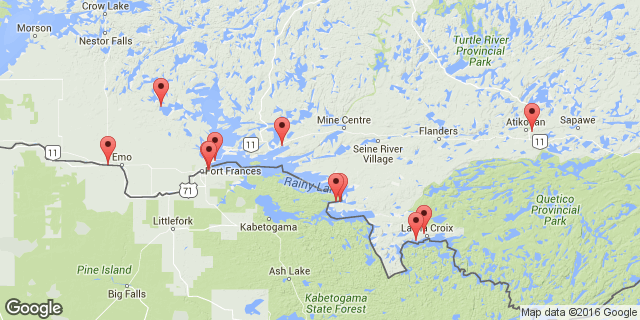

In [6]:
levelStations = ['05PB007','05PB024','05PB018','05PA006','05PA013', \
               '05PB023','05PC024','05PC025','05PA011','05PA003','05PC018']

mapWSC(levelStations)

### Flow Monitoring Stations

,STATION_NAME,LATITUDE,LONGITUDE
STATION_NUMBER,,,
05PC018,RAINY RIVER AT MANITOU RAPIDS,48.63447,-93.91336
05PC019,RAINY RIVER AT FORT FRANCES,48.60853,-93.40344
05PB014,TURTLE RIVER NEAR MINE CENTRE,48.85022,-92.72383


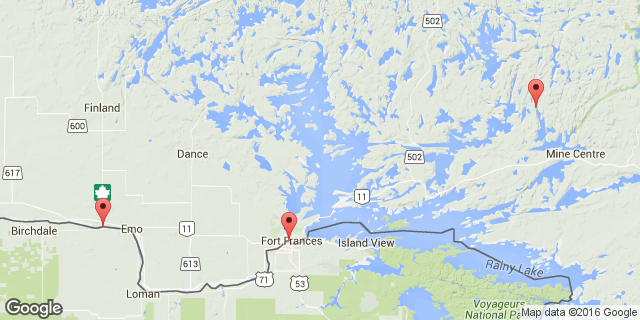

In [8]:
flowStations = ['05PC018','05PC019','05PB014']
mapWSC(flowStations)

## Create `hydat.h5` Data Cache

Reading the entire HYDAT database is a lengthy operation, and because of file size constraints, the entire data set can not be stored in a github repository or hosted on a docker server. For those reaaons, the an HDF5 data cache is created in the local repository to include selected data relevant to the Rainy/Namakan system.

In [23]:
if not isfile('data/hydat.h5'):
    print 'Creating data/hydat.h5'
    hydat = pd.HDFStore('../data/hydat.h5')
    
    # store data in hydat.h5
    hydat['STATIONS'] = STATIONS.ix[levelStations + flowStations]
    hydat['DLY_FLOWS'] = DLY_FLOWS[DLY_FLOWS['STATION_NUMBER'].isin(flowStations)]
    hydat['DLY_LEVELS'] = DLY_LEVELS[DLY_LEVELS['STATION_NUMBER'].isin(levelStations)]
    
    # reload from cache (to verify data round trip)
    STATIONS = hydat['STATIONS']
    DLY_LEVELS = hydat['DLY_LEVELS']
    DLY_FLOWS = hydat['DLY_FLOWS']
    
    hydat.close()
    
hydat

Creating data/hydat.h5


<class 'pandas.io.pytables.HDFStore'>
File path: ../data/hydat.h5
File is CLOSED

## Reading Daily Level Records

The next cell defines a utility function to create a Pandas Series containing the history of levels for a given WSC sensor. The returned object indexed with a daily timestamp.

In [10]:
def getLevelsWSC(s):
    global DLY_LEVELS
    data = DLY_LEVELS[DLY_LEVELS['STATION_NUMBER'] == s]
    ts = {}
    for k in data.index:
        mo = str(data.ix[k,'MONTH'])
        yr = str(data.ix[k,'YEAR'])
        for n in range(1,data.ix[k,'NO_DAYS']+1):
            ts[pd.to_datetime(mo+'/'+str(n)+'/'+yr)] = data.ix[k,'LEVEL'+str(n)]  
    ts = pd.Series(ts)
    ts.name = STATIONS.ix[s,'STATION_NAME'] + ' (' + s + ')'
    # drop initial and terminal null entries
    j = 0
    while pd.isnull(ts.ix[j]):
        j += 1
    k = len(ts.index) - 1
    while pd.isnull(ts.ix[k]):
        k += -1
    return ts[j:k]

#### Example: Comparing Levels on Rainy and Namakan Lakes

Use of this function is demonstrated by reading and plotting the history of lake levels for Rainy and Namakan Lakes.

In [11]:
RL = getLevelsWSC('05PB007')
NL = getLevelsWSC('05PA003')

<IPython.core.display.Javascript object>


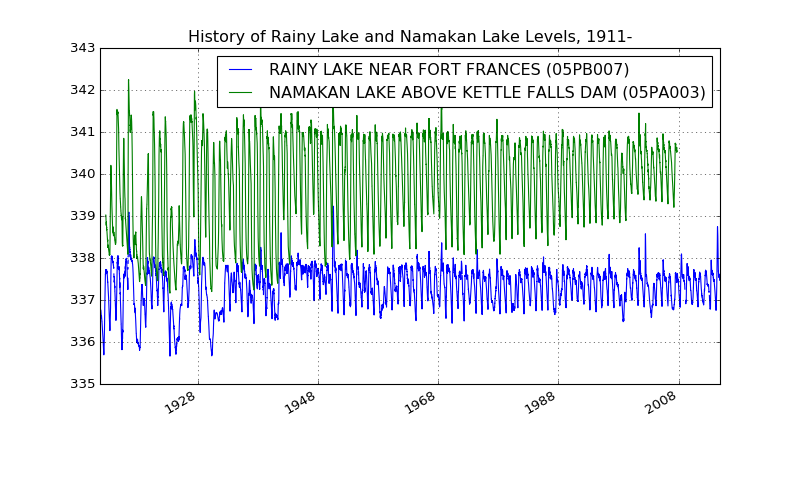

In [12]:
plt.figure(figsize=(10,6))
plt.hold(True)
RL.plot()
NL.plot()
plt.hold(False)
plt.legend([RL.name,NL.name]);
plt.title('History of Rainy Lake and Namakan Lake Levels, 1911-')
plt.grid()

## Reading Daily Flow Records

The next cell defines a utility function to create a Pandas Series containing the history of flow data for a given WSC sensor. The returned object indexed with a daily timestamp.

In [13]:
def getFlowsWSC(s):
    data = DLY_FLOWS[DLY_FLOWS['STATION_NUMBER'] == s]
    ts = {}
    for k in data.index:
        mo = str(data.ix[k,'MONTH'])
        yr = str(data.ix[k,'YEAR'])
        for n in range(1,data.ix[k,'NO_DAYS']+1):
            ts[pd.to_datetime(mo+'/'+str(n)+'/'+yr)] = data.ix[k,'FLOW'+str(n)]  
    ts = pd.Series(ts)
    ts.name = STATIONS.ix[s,'STATION_NAME'] + ' (' + s + ')'
    # drop initial and terminal null entries
    j = 0
    while pd.isnull(ts.ix[j]):
        j += 1
    k = len(ts.index) - 1
    while pd.isnull(ts.ix[k]):
        k += -1 
    return ts[j:k]

#### Example: Distribution of Flows on Rainy River

The use of this function is demonstrated by creating a historgram of flows on Rainy River in the period 

In [14]:
RR = getFlowsWSC('05PC019')
RM = getFlowsWSC('05PC018')

<IPython.core.display.Javascript object>


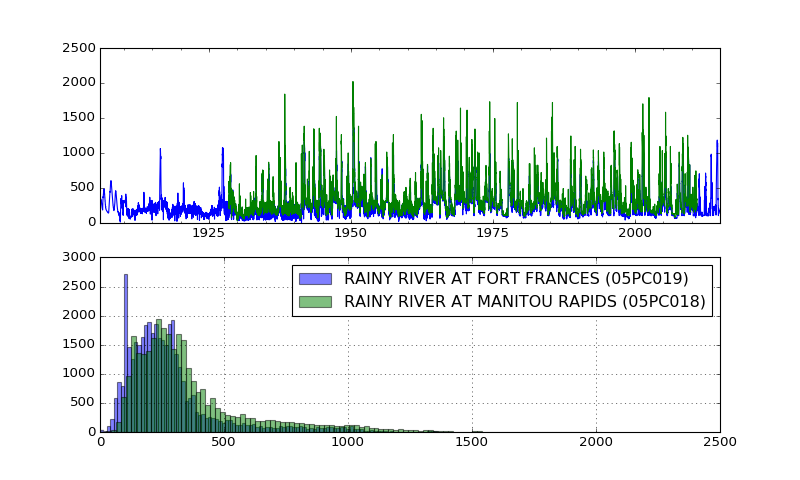

In [21]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.hold(True)
RR.plot()
RM.plot()
plt.hold(False)
plt.subplot(2,1,2)
plt.hold(True)
RR.hist(bins=100,alpha=0.5)
RM.hist(bins=100,alpha=0.5)
plt.hold(False)
plt.legend([RR.name,RM.name])
